# **Machine Learning to predict prices**

We have already cleaned up and filled in the missing values in our dataset. The final goal of the project was to be able to predict the Airbnb price of NYC listings based on different features provided - including reviews, host information, location, etc. We will take into account all of those factors and come up with a regression models to predict prices. We will compare and contrast the models to see which model performs the best in our dataset and which model would be capable of predicting the price accurately. 
The first thing that we need to do is feature engineering of the different kinds of features that we have. The features in our dataset are of various kinds - categorical, numerical, datetime, string and the machine learning models cannot work with such variables. So we have to engineer these features in a way that the models can understand, after which we will run the ML models.


In [0]:
# Importing the necessary packages

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import date 
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving airbnb_data_cleaned.csv to airbnb_data_cleaned (1).csv


In [3]:
#Importing the cleaned up dataset

import io
df = pd.read_csv(io.BytesIO(uploaded['airbnb_data_cleaned.csv']))
pd.options.display.max_columns = 600
df.head()

,neighborhood_overview,transit,access,interaction,house_rules,host_id,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,name_describe_host
0,0,1,1,1,1,2758,2008-09-06,In NY,within a few hours,0.70,1,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1,1,Harlem,Manhattan,10026.0,40.799205,-73.953676,1,Apartment,Private room,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",59.0,0.0,60.0,2,39.0,2,21,today,3,12,23,298,175,93.0,9.0,9.0,10.0,9.0,9.0,9.0,0,strict_14_with_grace_period,0,0,1.42,Stay at Chez Chic budget room #1 Step into our...
1,1,1,1,1,1,42032,2009-09-29,In NY,within a day,0.80,0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Upper West Side,Manhattan,10025.0,40.797642,-73.961775,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",140.0,0.0,40.0,2,28.0,5,365,yesterday,8,8,13,248,76,94.0,10.0,9.0,10.0,10.0,10.0,10.0,0,moderate,1,1,0.72,Light-filled classic Central Park An adorable...
2,1,1,0,0,1,2787,2008-09-07,In NY,within an hour,1.00,1,8.0,"['email', 'phone', 'reviews', 'kba']",1,1,Kensington,Brooklyn,11218.0,40.647486,-73.972370,0,Apartment,Private room,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",149.0,100.0,25.0,1,25.0,1,730,today,30,60,90,365,9,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,0,0.25,Clean & quiet apt home by the park Renovated a...
3,1,1,1,1,1,2845,2008-09-09,In NY,within a few hours,0.82,0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",1,1,Midtown,Manhattan,10018.0,40.753621,-73.983774,0,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,100.0,2,0.0,1,1125,3 days ago,15,45,75,350,41,95.0,9.0,9.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,1,1,0.37,Skylit Midtown Castle Find your romantic getaw...
4,1,1,1,1,1,82685,2010-02-18,In NY,did not respond,0.00,0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",1,1,Harlem,Manhattan,10031.0,40.828028,-73.947308,1,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",89.0,100.0,30.0,1,55.0,1,60,29 months ago,30,60,90,365,1,100.0,10.0,10.0,10.0,10.0,10.0,8.0,0,strict_14_with_grace_period,0,0,0.51,"Upper Manhattan, New York A great space in a b..."


**We will create a new dataframe - ml_df where we will concatenate the engineered features so we do not meddle with our original dataframe. This is the dataframe that we will eventually use to run our machine learning algorithms.**

In [0]:
# Adding the first 5 columns with 0/1 features indicating whether the information was not provided/provided
ml_df = df[['neighborhood_overview','transit','access','interaction','house_rules']]

**Host ID column contains identifying number for each host, these are randomly assigned numbers. There are certain hosts who have multiple listing, so some host IDs repeat several times. Instead of encoding each of the host IDs seperately, we will categorize the host ids into hosts with <50, >50 &<100, >100 listings. This will help us get an idea whether number of listings of host affect the listing prices.**


In [5]:
host_id = df[['host_id']]
host_id['count']=host_id.groupby(['host_id'])['host_id'].transform('count')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
def lists_binning(count):
    """Take in the count of listings and return which bin it falls into."""
    if count >100:
        return 'greater than 100'
    elif count <50:
        return 'less than 50'
    else:
        return '>50 and <100'

In [9]:
host_id['list_bins']=host_id['count'].apply(lists_binning)

listing_onehot_features = pd.get_dummies(host_id['list_bins'])
ml_df=pd.concat([ml_df, listing_onehot_features], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**We will use the year-month format to create a column and  run get dummies for that and include in ml_df. we will ignore the day. This will help us analyze if the month-year when the host joined Airbnb would affect the pricing of the host's listing.**

In [0]:
host_since=pd.to_datetime(df['host_since'], format='%Y-%m-%d')
host_since=host_since.to_frame()
host_since['host_since_ym']=host_since['host_since'].apply(lambda x: (str(x.year)+'-'+str(x.month)))

ym_onehot_features = pd.get_dummies(host_since['host_since_ym'])

ml_df=pd.concat([ml_df, ym_onehot_features], axis=1)

**One hot encoding for host location and host response times.**

In [0]:
location_onehot_features = pd.get_dummies(df['host_location'])
ml_df=pd.concat([ml_df, location_onehot_features], axis=1)

responsetime_onehot_features = pd.get_dummies(df['host_response_time'])
ml_df=pd.concat([ml_df, responsetime_onehot_features], axis=1)

**Scaling the host response rate on a scale of 100 and include that column in ml_df.**

In [12]:
response=df[['host_response_rate']]
response['host_response_rate_100'] = np.array(np.round((response['host_response_rate'] * 100)), dtype='int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Adding the host response rate scales to 100 and the other two columns with numerical values.**

In [0]:
ml_df = pd.concat([ml_df, response.host_response_rate_100, df.host_is_superhost,df.host_total_listings_count], axis=1)

**host verifications - number of verifications count of verifications included in ml_df**

In [14]:
verifications=df[['host_verifications']]
verifications['verification_count'] = verifications.host_verifications.map(lambda x: [i.strip() for i in x.split(",")])
verifications['verification_count'] = verifications.verification_count.apply(len)

ml_df = pd.concat([ml_df, verifications.verification_count], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
ml_df= pd.concat([ml_df, df.host_has_profile_pic, df.host_identity_verified], axis=1)

**One hot encoding for neighborhood cleansed and neighborhood group cleansed.**

In [0]:
nc_onehot_features = pd.get_dummies(df['neighbourhood_cleansed'])

ngc_onehot_features = pd.get_dummies(df['neighbourhood_group_cleansed'])

ml_df=pd.concat([ml_df, nc_onehot_features ,ngc_onehot_features], axis=1)

In [0]:
ml_df= pd.concat([ml_df, df.zipcode, df.latitude, df.longitude, df.is_location_exact], axis=1)

**One hot encoding for property type, room type and bed type.**

In [0]:
pt_onehot_features = pd.get_dummies(df['property_type'])

rt_onehot_features = pd.get_dummies(df['room_type'])

ml_df = pd.concat([ml_df, pt_onehot_features ,rt_onehot_features], axis=1)

In [0]:
ml_df=pd.concat([ml_df,df.accommodates,df.bathrooms,df.bedrooms,df.beds],axis=1)

In [0]:
bedt_onehot_features = pd.get_dummies(df['bed_type'])

ml_df = pd.concat([ml_df, bedt_onehot_features], axis=1)

**Converting amenities column to amenity counts - geting the count of number of amenities for each listing.**

In [21]:
amenities=df[['amenities']]
amenities['amenity_count'] = amenities.amenities.map(lambda x: [i.strip() for i in x.split(",")])
amenities['amenity_count'] = amenities.amenity_count.apply(len)

ml_df = pd.concat([ml_df, amenities.amenity_count], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
ml_df= pd.concat([ml_df, df.security_deposit, df.cleaning_fee, df.guests_included, df.extra_people,
                 df.minimum_nights, df.maximum_nights],axis=1)

**One hot encoding for calender updated  and cancellation policy columns.**

In [0]:
calendar_onehot_features = pd.get_dummies(df['calendar_updated'])

ml_df = pd.concat([ml_df, calendar_onehot_features], axis=1)

In [0]:
ml_df = pd.concat([ml_df, df.availability_30, df.availability_60, df.availability_90, df.availability_365,
                  df.number_of_reviews, df.review_scores_rating], axis=1)

**All review scores scaled to 100 instead of 10 and added to ml_df. This is done to make sure all discreete numerical variables are on a scale of 100, keeping it consistent.**

In [0]:
reviews = df[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value']]  
def multiply_10(x):
    return x*10
  
reviews = reviews.apply(multiply_10)

In [0]:
ml_df = pd.concat([ml_df, reviews, df.instant_bookable],axis=1)

In [0]:
cancel_onehot_features = pd.get_dummies(df['cancellation_policy'])

ml_df = pd.concat([ml_df, cancel_onehot_features], axis=1)

In [0]:
ml_df=pd.concat([ml_df, df.require_guest_profile_picture, df.require_guest_phone_verification], axis=1)

**Scaling reviews per month to 100**

In [33]:
df.reviews_per_month.describe()

count    48353.000000
mean         1.140344
std          1.605117
min          0.000000
25%          0.050000
50%          0.410000
75%          1.670000
max         20.330000
Name: reviews_per_month, dtype: float64

In [0]:
rpm=df[['reviews_per_month']]
max_rpm = float(max(rpm.values))

In [0]:
def scale_to_100(x):
    scaled= x/max_rpm *100
    scaled = round(scaled, 2)
    return scaled

In [0]:
rpm = rpm.apply(scale_to_100)

ml_df = pd.concat([ml_df, rpm],axis=1)

In [0]:
price = df[['price']]
ml_df = pd.concat([ml_df, price],axis=1)

In [38]:
ml_df.head()

,neighborhood_overview,transit,access,interaction,house_rules,>50 and <100,greater than 100,less than 50,2008-10,2008-11,2008-12,2008-8,2008-9,2009-1,2009-10,2009-11,2009-12,2009-2,2009-3,2009-4,2009-5,2009-6,2009-7,2009-8,2009-9,2010-1,2010-10,2010-11,2010-12,2010-2,2010-3,2010-4,2010-5,2010-6,2010-7,2010-8,2010-9,2011-1,2011-10,2011-11,2011-12,2011-2,2011-3,2011-4,2011-5,2011-6,2011-7,2011-8,2011-9,2012-1,2012-10,2012-11,2012-12,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2013-1,2013-10,2013-11,2013-12,2013-2,2013-3,2013-4,2013-5,2013-6,2013-7,2013-8,2013-9,2014-1,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-10,2015-11,2015-12,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2016-1,2016-10,2016-11,2016-12,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,2018-1,2018-10,2018-11,2018-12,2018-2,2018-3,2018-4,2018-5,2018-6,2018-7,2018-8,2018-9,In NY,In US but not in NY,Not Provided,Not in US,a few days or more,did not respond,within a day,within a few hours,within an hour,host_response_rate_100,host_is_superhost,host_total_listings_count,verification_count,host_has_profile_pic,host_identity_verified,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Richmondtown,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Wo

In [39]:
ml_df.shape

(48353, 552)

* ** Now we have a dataframe with all features engineered and encoded in a way that the ML algorithms would be able to understand and use. There are a total of 552 features.**

In [0]:
#ml_df.to_csv('ML_df_all_features.csv',index=False) 

**Making new dataframe with NLP features**

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def text_preprocess(input_str):
    input_str = input_str.lower()    # convert text to lowercase
    input_str = re.sub(r'\d+', '', input_str)    # remove numbers
    translator = str.maketrans('', '', string.punctuation)   # remove punctuations
    input_str = (input_str.translate(translator))
    input_str = re.sub(r'[^a-zA-Z\s]', '', input_str, re.I|re.A)    #remove special characters
    input_str = input_str.strip()    # remove white space
    return input_str

StopWords = stopwords.words("english")
def remove_stopwords(input_str):
    input_str = ' '.join([word for word in input_str.split() if word not in StopWords])
    return input_str

nlp = spacy.load('en_core_web_sm')
def lemmatize_text(input_str):
    input_str = nlp(input_str)
    input_str = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in input_str])
    return input_str

In [42]:
text = df[['name_describe_host']]
text['name_describe_host']=text['name_describe_host'].apply(text_preprocess)
text['name_describe_host']=text['name_describe_host'].apply(remove_stopwords)
text['name_describe_host']=text['name_describe_host'].apply(lemmatize_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [43]:
text.head()

,name_describe_host
0,stay chez chic budget room step artistic spaci...
1,lightfill classic central park adorable classi...
2,clean quiet apt home park renovate apt home el...
3,skylit midtown castle find romantic getaway be...
4,upper manhattan new york great space beautiful...


In [0]:
cv = CountVectorizer(min_df=0.05, max_df=0.95)
cv_matrix = cv.fit_transform(text.name_describe_host)
cv_matrix = cv_matrix.toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
bag_of_words=pd.DataFrame(cv_matrix, columns=vocab)

In [45]:
bag_of_words.shape

(48353, 331)

In [46]:
bag_of_words.head()

,ac,access,across,adventurer,air,airbnb,also,always,amazing,amenity,anything,apartment,appliance,apt,area,around,art,artist,ask,available,ave,avenue,away,back,backyard,bar,bath,bathroom,be,beautiful,bed,bedroom,big,block,book,br,brand,brick,bright,brooklyn,brownstone,build,building,bus,bushwick,business,cable,cafe,call,ceiling,center,central,chair,charming,check,city,clean,close,closet,coffee,come,comfortable,comfy,common,convenient,cook,cool,corner,couch,couple,cozy,culture,day,design,desk,different,dining,dishwasher,distance,district,do,door,doorman,downtown,dryer,east,easy,eat,elevator,email,enjoy,entire,entrance,equip,etc,every,everything,experience,explore,express,extra,family,feature,feel,find,first,flat,floor,food,foot,free,fresh,friend,friendly,front,full,fully,fun,furnish,furniture,garden,get,give,go,good,great,grocery,guest,gym,happy,hardwood,harlem,have,heart,height,help,hi,hide,high,historic,home,host,hour,house,huge,ideal,include,internet,keep,key,kitchen,know,large,laundry,leave,less,life,light,like,line,linen,little,live,living,local,locate,location,loft,long,look,lot,love,lovely,low,luxury,major,make,manhattan,many,market,master,mattress,may,meet,microwave,midtown,min,minute,modern,much,museum,music,name,natural,nd,near,nearby,need,neighborhood,netflix,new,newly,next,nice,night,not,note,ny,nyc,offer,old,one,open,park,parking,part,people,perfect,person,phone,place,please,plenty,prime,privacy,private,professional,prospect,provide,public,queen,question,quiet,read,really,relax,renovate,rent,restaurant,ride,right,river,rooftop,room,roommate,safe,second,see,separate,service,share,shop,shopping,short,shower,side,size,sleep,small,sofa,soho,solo,space,spacious,spot,square,st,state,station,stay,step,stop,store,street,studio,subway,sunny,super,supermarket,table,take,text,th,there,thing,three,throughout,time,ton,top,towel,town,train,transportation,travel,traveler,try,tv,two,union,unit,upper,us,use,via,view,village,visit,walk,walking,wall,want,washer,way,welcome,well,west,whole,wifi,will,williamsburg,window,within,wonderful,work,world,would,year,york,you,young
0,1,0,2,0,0,1,0,0,0,0,0,2,0,2,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,1,2,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,1,0,1,0,0,0,1,0,3,0,0,2,0,0,0,1,1,0,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,1,0,0,3,0,0,0,0,0,2,2,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,3,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,2,0,3,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

* **We created a bag of words datafame which contains the count of each word in all th listings. Based on the filters applied, we look at the 331 words that lie within the range we determined. Before doing countvectorization, the strings were pre processed - to remove unwanted non-english characters, lemmetizing the data and removing stop words. We will include this as recquired while training our machine learning models.**

In [0]:
#bag_of_words.to_csv('nlp_df.csv',index=False) 

**Creating a separate dataframe with fewer features. Certain features which had many unique catgorical values, resulted in producing many new features while doing the onehot encoding. So, those features are removed from the analysis. (no dates, neighbourhood, property type, calender updated)**

In [0]:
ml_df_less = pd.concat([df.neighborhood_overview, df.transit, df.access, df.interaction, df.house_rules,
                       listing_onehot_features, location_onehot_features,responsetime_onehot_features,
                       response.host_response_rate_100, df.host_is_superhost,df.host_total_listings_count,
                       verifications.verification_count, df.host_has_profile_pic, df.host_identity_verified,
                       ngc_onehot_features,df.zipcode, df.latitude, df.longitude, df.is_location_exact,
                       rt_onehot_features,df.accommodates,df.bathrooms,df.bedrooms,df.beds,bedt_onehot_features,
                       amenities.amenity_count, df.security_deposit, df.cleaning_fee, df.guests_included, 
                       df.extra_people, df.minimum_nights, df.maximum_nights, df.availability_30, df.availability_60, 
                       df.availability_90, df.availability_365, df.number_of_reviews, df.review_scores_rating, 
                       reviews, df.instant_bookable, df.require_guest_profile_picture, 
                       df.require_guest_phone_verification, rpm, price], axis=1)

In [48]:
ml_df_less.shape

(48353, 68)

******

# **Now that the dataframes are ready and encoded appropriately, we can move on to running machine learning algorithms for regression.**

In [8]:
from google.colab import files
uploaded = files.upload()

Saving ML_df_all_features.csv to ML_df_all_features.csv


In [0]:
import io
ml_df = pd.read_csv(io.BytesIO(uploaded['ML_df_all_features.csv']))

In [0]:
#ml_df=pd.read_csv('ML_df_all_features.csv')

In [10]:
uploaded = files.upload()

Saving nlp_df.csv to nlp_df.csv


In [0]:
nlp_df= pd.read_csv(io.BytesIO(uploaded['nlp_df.csv']))

ml_nlp_df = pd.concat([ml_df, nlp_df], axis=1)    #creating a dataframe with nlp features included 

**Outliers tend to skew the data and have a great impact on the results. So, before moving on the first step is to remove any outliers. To do that, we will look at any prices that are obvious outliers and remove those listing from the analysis.**

In [0]:
q = ml_df["price"].quantile(0.90)
ml_df_o = ml_df[ml_df["price"] < q]

### **1. Run all models without NLP**

In [0]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
    return (X_train, X_test, y_train, y_test)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor 
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

def run_models(X_train, X_test, y_train, y_test):
    scores ={}
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    scores['linear_regression']={'train':lm.score(X_train, y_train), 'test':lm.score(X_test, y_test)}

    decision_tree = tree.DecisionTreeRegressor(max_features='sqrt', min_impurity_decrease=0.5)
    tree_model = decision_tree.fit(X_train, y_train)
    scores['decision_tree']={'train':tree_model.score(X_train, y_train), 'test':tree_model.score(X_test, y_test)}

    random_forest = RandomForestRegressor(n_estimators=50, max_features='sqrt')
    rf_model = random_forest.fit(X_train, y_train)
    scores['random_forest']={'train':rf_model.score(X_train, y_train), 'test':rf_model.score(X_test, y_test)}

    gradient_boost = GradientBoostingRegressor()
    gb_model = gradient_boost.fit(X_train, y_train)
    scores['gradient_boost']={'train':gb_model.score(X_train, y_train), 'test':gb_model.score(X_test, y_test)}

    ada_boost = AdaBoostRegressor()
    ada_model = ada_boost.fit(X_train, y_train)
    scores['adaboost']={'train':ada_model.score(X_train, y_train), 'test':ada_model.score(X_test, y_test)}

    knn = KNeighborsRegressor()
    knn_model = knn.fit(X_train, y_train)
    scores['KNN']={'train':knn_model.score(X_train, y_train), 'test':knn_model.score(X_test, y_test)}

    xg_reg = xgb.XGBRegressor(objective ='reg:linear')
    xg_reg.fit(X_train,y_train)
    scores['XGboost']={'train':xg_reg.score(X_train, y_train), 'test':xg_reg.score(X_test, y_test)}

    cat_boost=CatBoostRegressor(iterations=50,loss_function='RMSE')
    cat_boost.fit(X_train, y_train, verbose=False)
    scores['catboost']={'train':(cat_boost.score(X_train, y_train))/100, 'test':(cat_boost.score(X_test, y_test))/100}
    
    return scores

In [0]:
ml_df_o_noprice = ml_df_o.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_df_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_o_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_df_o_noprice, ml_df_o.price)


In [0]:
model_scores = run_models(X_train, X_test, y_train, y_test)

In [63]:
models = pd.DataFrame(model_scores)
models = models.T
models.sort_values(['test'], ascending=False, inplace=True)
models

,test,train
gradient_boost,0.675401,0.679908
XGboost,0.675247,0.678989
random_forest,0.670776,0.951180
linear_regression,0.641840,0.649427
adaboost,0.475180,0.485465
catboost,0.467113,0.474608
decision_tree,0.435870,0.468894
KNN,0.291431,0.520236


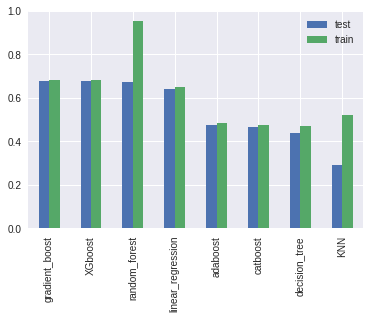

In [64]:
models.plot(kind='bar')

### **2. Running all models on dataframe with NLP features included**

In [0]:
ml_nlp_df_o = ml_nlp_df[ml_nlp_df['price'] < q]

In [0]:
ml_nlp_df_o = ml_nlp_df_o.loc[:, ~ml_nlp_df_o.columns.duplicated()]

In [0]:
ml_nlp_df_o_noprice = ml_nlp_df_o.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_nlp_df_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_nlp_df_o_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_nlp_df_o_noprice, ml_nlp_df_o.price)

In [0]:
model_scores_nlp = run_models(X_train, X_test, y_train, y_test)

In [69]:
models_nlp = pd.DataFrame(model_scores_nlp)
models_nlp = models_nlp.T
models_nlp.sort_values(['test'], ascending=False, inplace=True)
models_nlp

,test,train
gradient_boost,0.678520,0.683717
XGboost,0.677493,0.682464
linear_regression,0.655102,0.669769
random_forest,0.653133,0.948621
catboost,0.471799,0.479138
decision_tree,0.440207,0.502148
KNN,0.293304,0.520328
adaboost,0.243498,0.269088


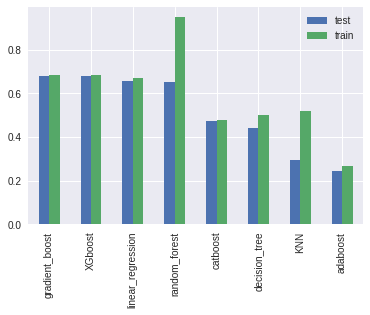

In [70]:
models_nlp.plot(kind='bar')

### **3. Running models on ml_df_less - without neighborhood, host joined date, property type, calender updated - because those columns had many unique values which increased the number of features drastically. Only running the model on 68 features**

In [71]:
ml_df_less.shape

(48353, 68)

In [0]:
q = ml_df_less["price"].quantile(0.90)
ml_df_less_o = ml_df_less[ml_df_less["price"] < q]     #remove outlier price rows

In [0]:
ml_df_less_o_noprice = ml_df_less_o.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_df_less_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_less_o_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_df_less_o_noprice, ml_df_less_o.price)


In [0]:
model_scores_less = run_models(X_train, X_test, y_train, y_test)

In [75]:
models_less = pd.DataFrame(model_scores_less)
models_less = models_less.T
models_less.sort_values(['test'], ascending=False, inplace=True)
models_less

,test,train
random_forest,0.680241,0.952854
gradient_boost,0.674681,0.678718
XGboost,0.673583,0.677976
linear_regression,0.582592,0.584087
decision_tree,0.578975,0.618979
catboost,0.463596,0.470812
adaboost,0.421258,0.436019
KNN,0.290944,0.520378


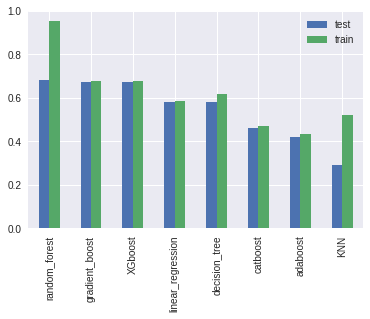

In [76]:
models_less.plot(kind='bar')

### 4. Running the models after removing features with low variances

In [0]:
from sklearn.feature_selection import VarianceThreshold

X = ml_df_o_noprice

sel = VarianceThreshold(threshold=(0.5))
X_new = sel.fit_transform(X)

X_train, X_test, y_train, y_test = split_data(X_new, ml_df_o.price)

In [0]:
model_scores_low_variance = run_models(X_train, X_test, y_train, y_test)

In [79]:
models_low_variance = pd.DataFrame(model_scores_low_variance)
models_low_variance = models_low_variance.T
models_low_variance.sort_values(['test'], ascending=False, inplace=True)
models_low_variance

,test,train
random_forest,0.591450,0.939080
XGboost,0.591122,0.591372
gradient_boost,0.587365,0.589188
catboost,0.492851,0.504495
decision_tree,0.447765,0.516506
linear_regression,0.383727,0.369767
KNN,0.288134,0.517621
adaboost,0.248834,0.264781


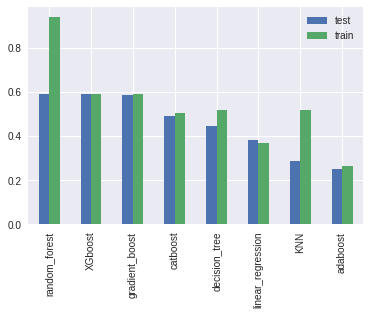

In [80]:
models_low_variance.plot(kind='bar')

### 5. Running the model after selecting features using Select from Model

In [0]:
from sklearn.feature_selection import SelectFromModel

In [0]:
X = ml_df_o_noprice
y = ml_df_o.price

model = GradientBoostingRegressor()

sfm = SelectFromModel(model, max_features=150)
X_new = sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = split_data(X_new, y)

In [0]:
model_scores_sfm = run_models(X_train, X_test, y_train, y_test)

In [83]:
models_sfm = pd.DataFrame(model_scores_sfm)
models_sfm = models_sfm.T
models_sfm.sort_values(['test'], ascending=False, inplace=True)
models_sfm

,test,train
random_forest,0.686692,0.953533
gradient_boost,0.673518,0.677073
XGboost,0.672641,0.676585
decision_tree,0.582416,0.633044
linear_regression,0.565102,0.564368
catboost,0.461665,0.469323
adaboost,0.422253,0.435320
KNN,0.340674,0.553235


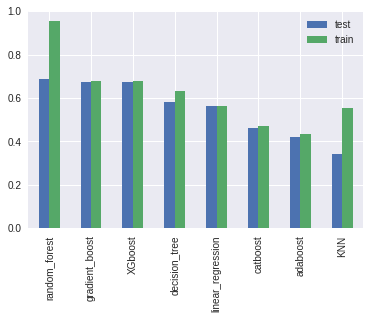

In [84]:
models_sfm.plot(kind='bar')

### **6. Running models after one hot encoding zipcodes**

In [0]:
top50_zipcode = (list(dict(ml_df_o.zipcode.value_counts().head(50)).keys()))

In [0]:
def fill_zipcode(code):
    if code in top50_zipcode:
        return code
    else:
        return 'other'

In [0]:
ml_df_zipcode = ml_df_o.copy(deep=True)
ml_df_zipcode.zipcode = ml_df_zipcode.zipcode.apply(fill_zipcode)

In [0]:
zipcode_onehot_features = pd.get_dummies(ml_df_zipcode['zipcode'])

ml_df_zipcode = pd.concat([ml_df_zipcode, zipcode_onehot_features], axis=1)

ml_df_zipcode = ml_df_zipcode.drop('zipcode', axis=1)

In [0]:
ml_df_zipcode_noprice = ml_df_zipcode.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_df_zipcode_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_zipcode_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_df_zipcode_noprice, ml_df_zipcode.price)


In [0]:
model_scores_zipcode = run_models(X_train, X_test, y_train, y_test)

In [93]:
model_scores_zipcode = pd.DataFrame(model_scores_zipcode)
model_scores_zipcode = model_scores_zipcode.T
model_scores_zipcode

,test,train
KNN,0.251398,0.487492
XGboost,0.675706,0.680023
adaboost,0.432159,0.444015
catboost,0.466755,0.474005
decision_tree,0.482042,0.513619
gradient_boost,0.674315,0.679570
linear_regression,0.643292,0.653536
random_forest,0.672147,0.950723


In [0]:
model_scores_zipcode.sort_values(['test'], ascending=False, inplace=True)

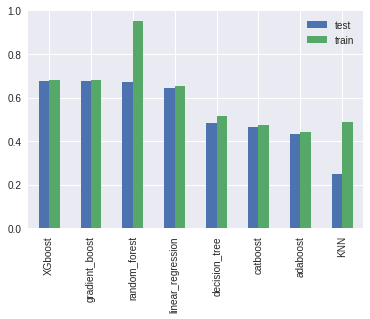

In [95]:
model_scores_zipcode.plot(kind='bar', sort_columns=True)

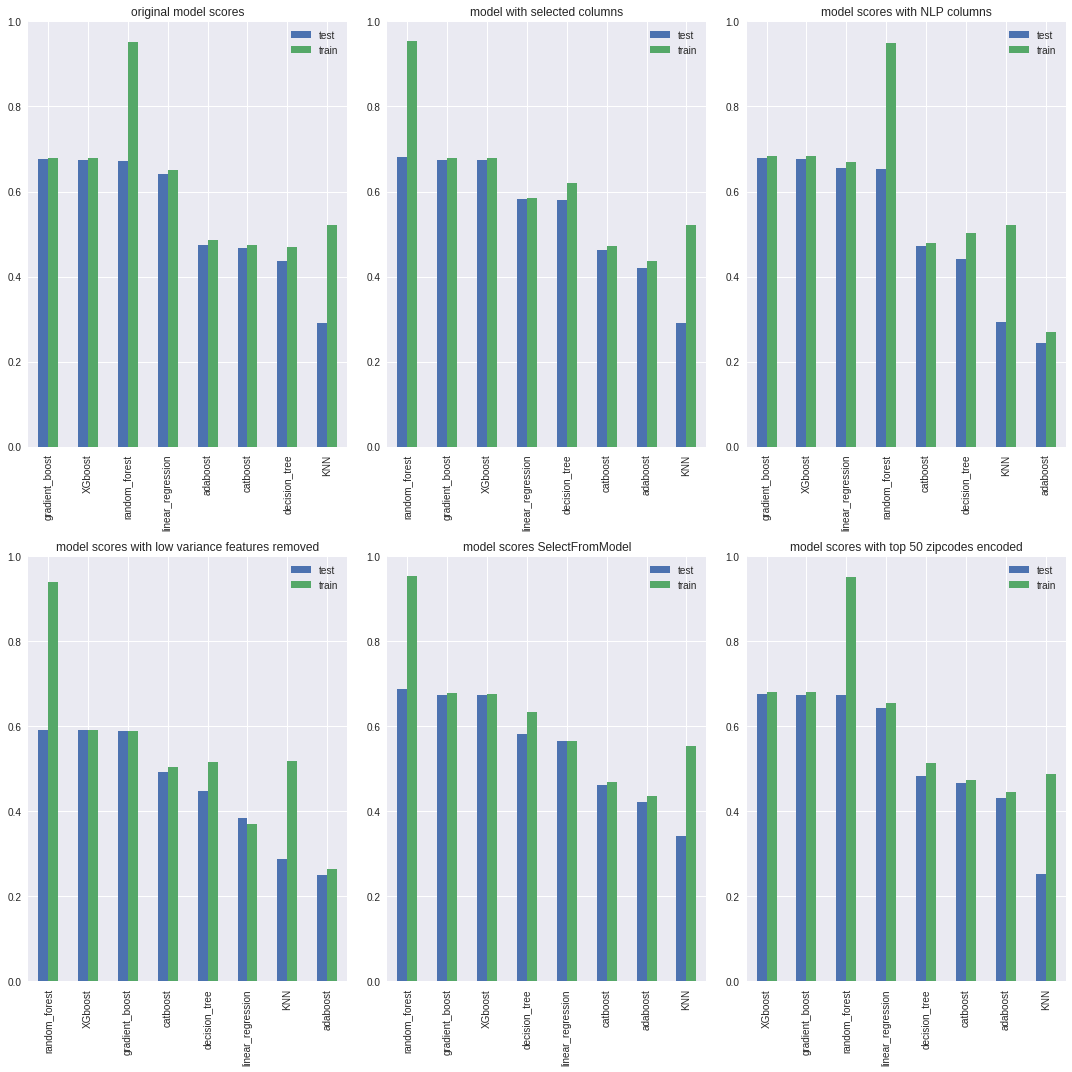

In [96]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

models.plot(kind='bar', ax=ax1)
ax1.set_title('original model scores')
ax1.set_ylim(0,1)

models_less.plot(kind='bar', ax=ax2)
ax2.set_title('model with selected columns')
ax2.set_ylim(0,1)

models_nlp.plot(kind='bar', ax=ax3)
ax3.set_title('model scores with NLP columns')
ax3.set_ylim(0,1)

models_low_variance.plot(kind='bar', ax=ax4)
ax4.set_title('model scores with low variance features removed')
ax4.set_ylim(0,1)

models_sfm.plot(kind='bar', ax=ax5)
ax5.set_title('model scores SelectFromModel')
ax5.set_ylim(0,1)

model_scores_zipcode.plot(kind='bar', ax=ax6)
ax6.set_title('model scores with top 50 zipcodes encoded')
ax6.set_ylim(0,1)
plt.tight_layout()


## **The top 3 performing models are : XGboost, random forest and gradient boosting. Random forest seems to be over fitting in most cases. But we can continue with these models and try and increase the score by chaanging hyperparameters.**

In [0]:
model_score_dict = [models, models_less, models_nlp, models_low_variance, models_sfm, model_scores_zipcode]

In [98]:
random_forest={}
XGboost={}
gradient_boost={}
models = {0:'original model', 1:'model with fewer features', 2:'model with NLP features', 
         3:'model with low variance features removed', 4:'models with SelectFromModel features', 
         5:'model with zipcode encoded'}

for index, model in enumerate(model_score_dict):
    random_forest[index] = model.loc['random_forest','test']
    XGboost[index] = model.loc['XGboost','test']
    gradient_boost[index] = model.loc['gradient_boost','test']

print('Highest performing random forest model is : ', models[max(random_forest, key=random_forest.get)])
print('Highest performing XGboost model is : ', models[max(XGboost, key=XGboost.get)])
print('Highest performing gradient boosting model is : ', models[max(gradient_boost, key=gradient_boost.get)])

Highest performing random forest model is :  models with SelectFromModel features
Highest performing XGboost model is :  model with NLP features
Highest performing gradient boosting model is :  model with NLP features


### **Trying to improve the score using Random Forest - Random Search CV and Grid Search CV**

In [0]:
X = ml_df_o_noprice
y = ml_df_o.price

model = GradientBoostingRegressor()

sfm = SelectFromModel(model, max_features=150)
X_new = sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = split_data(X_new, y)

In [102]:

random_forest_reg = RandomForestRegressor(n_estimators=50, max_features='sqrt')
random_forest_reg.fit(X_train, y_train)

print('Parameters currently in use:\n', random_forest_reg.get_params())
print('\n train score: ', random_forest_reg.score(X_train, y_train), 'test score:',random_forest_reg.score(X_test, y_test))


Parameters currently in use:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

 train score:  0.9535067715440667 test score: 0.6871455541865635


In [103]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [50,100,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [25,50,75,100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [50, 100, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [25, 50, 75, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3]}


In [104]:
rfr_random = RandomizedSearchCV(estimator=random_forest_reg, param_distributions=random_grid,
                              n_iter = 10, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=6, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rfr_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [25, 50, 75, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=6, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=2)

In [105]:
rfr_random.best_params_

{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [0]:
rf = RandomForestRegressor(n_estimators=150, min_samples_split=2,min_samples_leaf=3,max_features='auto', max_depth=50)


In [108]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [109]:
rf.score(X_test, y_test)

0.6843971551278097

In [0]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'max_depth': [40, 50, 60],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [2,3],
    'n_estimators': [150, 200, 250],
    'max_depth': [50]}

# Create a base model
rf = RandomForestRegressor(random_state = 6)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [111]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  9.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=6, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [50], 'max_features': ['auto'], 'min_samples_leaf': [3, 4], 'min_samples_split': [2, 3], 'n_estimators': [150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [112]:
grid_search.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 250}

In [113]:
param_grid = {'max_depth': [50],
    'max_features': ['auto'],
    'min_samples_leaf': [3],
    'min_samples_split': [2],
    'n_estimators': [500, 1000],
    'max_depth': [50]}

# Create a base model
rf = RandomForestRegressor(random_state = 6)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=6, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [50], 'max_features': ['auto'], 'min_samples_leaf': [3], 'min_samples_split': [2], 'n_estimators': [500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [114]:
grid_search.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [45]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=2,min_samples_leaf=3,max_features='auto', max_depth=50)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [116]:
rf.score(X_test, y_test)

0.6850766301287504

**The score for random forest regressor did not imporve much even after trying to find optimal praameters usinf grid search. We got a slight increase in score but not a significant difference**
******

## **Next, we will try to optimize the parameters for gradient boosting as that was also a pretty high scoring algorithm on our data. We can try to see if the scores will imporve with hypermeter optimization.**

In [0]:
ml_nlp_df_o_noprice = ml_nlp_df_o.drop('price', axis=1)

X_train, X_test, y_train, y_test = split_data(ml_nlp_df_o_noprice, ml_nlp_df_o.price)

In [18]:
model = GradientBoostingRegressor()
model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics.regression import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope
import numpy as np

In [0]:
#scope.define(GradientBoostingRegressor)    

def objective_function_regression(estimator):
    mse_array = cross_val_score( estimator, X_train, y_train, cv= 2, n_jobs=-1, scoring = make_scorer(mse) )
    return mse_array.mean()

In [0]:
# search space
n_estimators     = hp.randint('n_estimators',1000) 
learning_rate    = hp.loguniform('learning_rate',-3,1)
max_depth        = hp.randint('max_depth', 10)
max_features     = hp.randint('max_features',X_train.shape[1])
min_samples_leaf = hp.randint('min_samples_leaf', 10)

In [0]:
# model / estimator to be optimized
est0 = (0.1, scope.GradientBoostingRegressor( loss = 'ls', alpha = 0.5, n_estimators  = n_estimators + 1,
                                             learning_rate = learning_rate, max_depth = max_depth + 1,
                                            max_features = max_features + 1, min_samples_leaf = min_samples_leaf + 1,
                                             random_state= 6) )
search_space_regression = hp.pchoice('estimator', [est0])


In [25]:
best = fmin(fn= objective_function_regression,space= search_space_regression, algo = tpe.suggest, max_evals = 3, 
           verbose=2)

100%|██████████| 3/3 [01:44<00:00, 32.24s/it, best loss: 1156.3509159844461]


In [0]:
# Allocate optimized parameters and apply to test data set
Regressor = GradientBoostingRegressor( loss = 'ls', alpha = 0.5, learning_rate = best['learning_rate'],
                                      max_depth = best['max_depth'], max_features = best['max_features'],
                                      min_samples_leaf = best['min_samples_leaf'], n_estimators = best['n_estimators'],
                                      random_state = 6)

In [27]:
Regressor.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.5, criterion='friedman_mse', init=None,
             learning_rate=0.06986117403288669, loss='ls', max_depth=1,
             max_features=94, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=6, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=416,
             n_iter_no_change=None, presort='auto', random_state=6,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [28]:
Regressor.score(X_test, y_test)

0.6424290268156735

In [29]:
yhat = Regressor.predict(X_test) ;
error_pct = np.round( np.median(np.abs(yhat - y_test)), 2)

print("{} {}".format('The Median Abs. Error (%) for the test set is :', error_pct))

The Median Abs. Error (%) for the test set is : 20.25


## **The hyperparameter optimization did not affect the score by a significant margin. The best score for the data was achieved using the random boosting regressor which was ~68%.**

In [62]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = split_data(X, y)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

In [64]:
feature_importances.head(20)

,importance
Entire home/apt,0.581474
longitude,0.091181
latitude,0.061908
accommodates,0.059044
cleaning_fee,0.042121
zipcode,0.034622
bedrooms,0.025133
host_total_listings_count,0.011510
minimum_nights,0.011397
Manhattan,0.009516


**Here, we find out the top 20 features that contribute the the price prediction and have the hightest feature importances. The type of apartment/room, the location and availabilities seem to be among the top few important features**